<a href="https://colab.research.google.com/github/DENGCPU/PyTorch-Study/blob/main/PyTorch%E5%9B%BE%E5%83%8F%E5%88%86%E7%B1%BB%E5%99%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 使用CIFAR10数据集，，它包含十个类别：‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’。
# CIFAR-10 中的图像尺寸为33232，
# 也就是RGB的3层颜色通道，每层通道内的尺寸为32*32

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)
trainset = torchvision.datasets.CIFAR10(root='./data',train=True,
                                       download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=4,
                                          shuffle=True,num_workers=2)
testset  = torchvision.datasets.CIFAR10(root='./data',train=False,
                                        download=True,transform =transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=4,
                                         shuffle=False,num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:02<00:00, 66163765.81it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


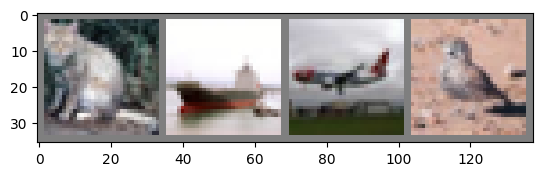

  cat  ship plane  bird


In [4]:
# 展示一些训练图片
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  #反归一化
  img = img / 2 + 0.5
  npimg = img.numpy()
  #转置
  # 在PyTorch和TensorFlow等深度学习框架中，图像的维度顺序通常是(通道数, 高度, 宽度)
  # 然而，对于matplotlib.imshow()函数，图像的维度顺序应该是(高度, 宽度, 通道数)
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [5]:
# 定义一个卷积神经网络

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


In [6]:
# 定义一个损失函数Cross-Entropy和优化器SGD
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

for epoch in range(2):
  running_loss = 0.0
  for i ,data in enumerate(trainloader,0):
    inputs, labels = data
    optimizer.zero_grad()
    #forward+ backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs,labels)
    optimizer.step()

    running_loss += loss.item()
    if i% 2000 ==1999:
      print('[%d, %5d] loss: %.3f' %
            (epoch+1 ,i+1, running_loss / 2000))
      running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.304
[1,  4000] loss: 2.304
[1,  6000] loss: 2.304
[1,  8000] loss: 2.303
[1, 10000] loss: 2.304
[1, 12000] loss: 2.304
[2,  2000] loss: 2.304
[2,  4000] loss: 2.305
[2,  6000] loss: 2.303
[2,  8000] loss: 2.303
[2, 10000] loss: 2.304
[2, 12000] loss: 2.305
Finished Training


In [7]:
outputs = net(images)

_,predicted = torch.max(outputs,1)

print('Predicted:', ','.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted: plane,plane,plane,plane


In [8]:
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images,labels = data
    outputs = net(images)
    _,pretdicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct /total)
)


Accuracy of the network on the 10000 test images: 10 %


In [9]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in testloader:
    images,labels=data
    outputs=net(images)
    _,predicted=torch.max(outputs,1)
    c= (predicted==labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label]+=c[i].item()
      class_total[label]+=1

for i in range(10):
  print('Accuracy of %5s: %2d %%' % (
      classes[i], 100 *class_correct[i] / class_total[i]
  ))

Accuracy of plane: 100 %
Accuracy of   car:  0 %
Accuracy of  bird:  0 %
Accuracy of   cat:  0 %
Accuracy of  deer:  0 %
Accuracy of   dog:  0 %
Accuracy of  frog:  0 %
Accuracy of horse:  0 %
Accuracy of  ship:  0 %
Accuracy of truck:  0 %


In [10]:
# 在GPU上跑
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [11]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [12]:
inputs, labels=inputs.to(device), labels.to(device)